# Imports

In [150]:
import numpy as np
import matplotlib.pyplot as plt

# Data Files

In [151]:
import glob


# Find all text files starting with "out"
fileListData = glob.glob("out*.txt")

# Array with the energy values
ee = []

# Organize the data into arrays
dataArr = []
for file in fileListData:
    _, N, gam = file.split("-")
    N, gam = int(N), float(gam[:-4])
    
    # Load the file as an array of strings
    data = np.loadtxt(file)
    dataArr += [(N, gam, data)]

    ee = data[0, :]


# Find all text files starting with "time"
fileListTime = glob.glob("time*.txt") 

# Get time data
ttArr, rrArr, uuArr = [], [], []
for fileName in fileListTime:
    with open(fileName, "r") as file:
        text = file.read().split("\n")
        text = [item for item in text if len(item) > 2]

    tt, rr, uu = [], [], []
    for index in range(len(text) // 4):
        index *= 4
        tt += [int(text[index].split("=")[-1])]
        rr += [float(text[index + 1].split("m")[-1][:-1])]
        uu += [float(text[index + 2].split("m")[-1][:-1])]

    ttArr += [tt]
    rrArr += [rr]
    uuArr += [uu]

ttArr = np.array(ttArr)
rrArr = np.array(rrArr)
uuArr = np.array(uuArr)

# Density of States

In [152]:
# Graphene bands (length in units of a and energy in units of t)
def energy_band(kx, ky):
    term1 = np.cos(kx * np.sqrt(3))
    term2 = np.cos(kx * np.sqrt(3) / 2) * np.cos(ky * 3 / 2)
    return np.sqrt(3 + 2 * term1 + 4 * term2)


def gaussian(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))


def dosExact(Nk = 250, Maxk = 10, sigma = 0.05):
    global ee

    # Generate mesh
    u = np.linspace(-Maxk, Maxk, Nk)
    v = np.linspace(-Maxk, Maxk, Nk)
    uu, vv = np.meshgrid(u, v)

    # Calculate eigenvalues
    bb = energy_band(uu, vv).flatten()
    bb = list(bb) + list(-bb)

    # Calculate DOS
    dataExact = np.zeros_like(ee)
    for energy in bb:
        dataExact += gaussian(ee, energy, sigma)
    
    return dataExact / Nk**2

dataExact = dosExact()

# Visualization

In [153]:
def plotAll(dataArr: list, dataExact: list, cols: int) -> None:
    # Needed number of columns
    rows = len(dataArr) // cols + 1

    plt.figure(figsize=(cols * 6, rows * 4))
    for index, item in enumerate(dataArr):
        
        # Getting data
        N, gam, data = item

        # Plotting
        plt.subplot(rows, cols, index+1)
        plt.title(f"Density of states for $N$ = {N} and $\\gamma$ = {gam:.2f}")
        plt.plot(data[0, :], data[1, :], label="Numeric DOS")
        plt.xlabel("$\\varepsilon$")
        plt.ylabel("$\\rho(\\varepsilon)$")

        # Plotting
        plt.plot(data[0, :], dataExact, label="Thermodynamic DOS")
        plt.legend()

    plt.subplots_adjust(hspace=0.35)
    plt.show()

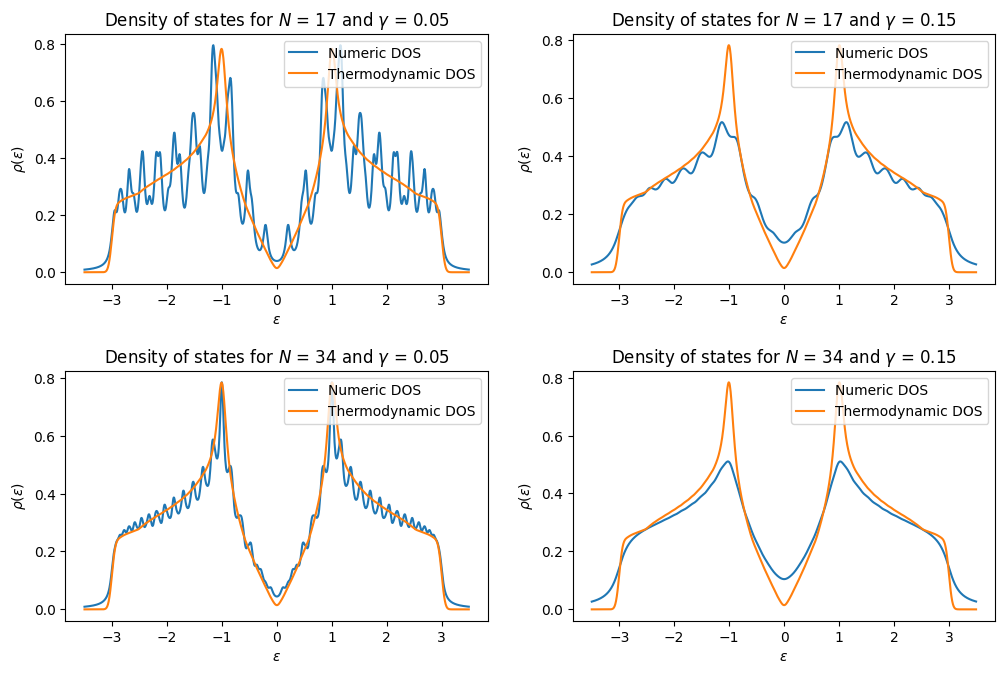

In [154]:
# See all the DOS
plotAll(dataArr, dataExact, 2)

# Parallelization

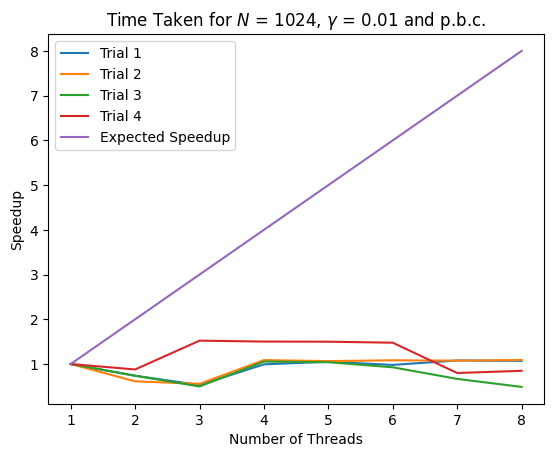

In [155]:
plt.title(f"Time Taken for $N$ = {1024}, $\\gamma$ = {0.01} and {'p.' if True else 'o.'}b.c.")
for tt, rr, index in zip(ttArr, rrArr, range(0, len(ttArr))):
    plt.plot(tt, rr[0] / rr, label=f"Trial {index+1}")

plt.plot(tt, tt, label="Expected Speedup")
plt.xlabel("Number of Threads")
plt.ylabel("Speedup")
plt.legend()